In [6]:
import os
import numpy as np
import h5py
import cv2
import tqdm
import matplotlib.pyplot as plt

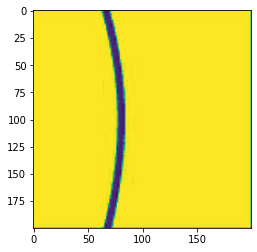

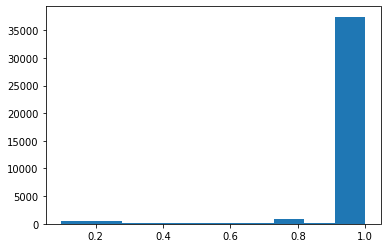

observations shape (1, 200, 200)


In [7]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'train.hdf5')
h5py_file = h5py.File(filename, 'r')
observations = h5py_file['dataset']['observations']
plt.imshow(observations[1000].swapaxes(0,1).swapaxes(1,2)[:,:,0])
plt.show()
plt.hist(observations[1000].flatten())
plt.show()
print(f'observations shape {observations[0].shape}')

In [8]:
len(observations)

3025

(1, 200, 200)


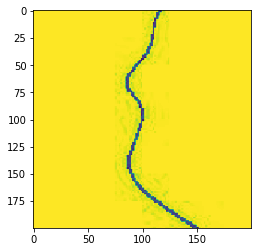

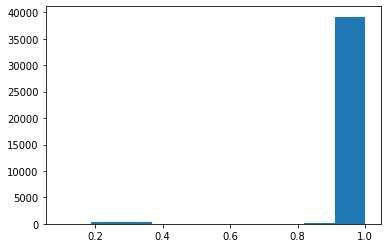

In [3]:
# change shape
size = [1, 200, 200]
preprocessed_observations = [
    cv2.resize(o.swapaxes(0,1).swapaxes(1,2), dsize=(size[1], size[2]), 
               interpolation=cv2.INTER_NEAREST).mean(axis=-1, keepdims=True).swapaxes(1, 2).swapaxes(0, 1) 
    for o in observations
]
print(preprocessed_observations[0].shape)
plt.imshow(preprocessed_observations[1000][0])
plt.show()
plt.hist(preprocessed_observations[1000].flatten())
plt.show()

In [4]:
# write preprocessed images to new h5py file:
filename = '/home/klaas/line_world_sim_dronet.hdf5'
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [preprocessed_observations, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

In [5]:
# threshold regions in image
threshold = 0.5
binary_images = [
    cv2.threshold(o[0],0.5,1,cv2.THRESH_BINARY)[1] for o in observations
]
print(binary_images[0])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [6]:
# fill in zero (fg) and one (bg) regions
final_images = []
for img in binary_images:
    # pick bg and fg color
    minimal_contrast = 0.1
    bg = np.random.uniform(0, 1)
    fg = np.random.uniform(0, 1)
    while bg-fg > minimal_contrast:
        fg = np.random.uniform(0, 1)
    img[img==0] = fg
    img[img==1] = bg
    final_images.append(np.expand_dims(img, axis=0))
    
assert final_images[0].shape == (1, 200, 200)

In [7]:
# write augmented dataset
filename = '/home/klaas/line_world_sim_dronet_augmented.hdf5'
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [final_images, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

In [6]:
# create noise augmented dataset
final_images = []
for img in binary_images:
    bg = np.random.uniform(0, 1, size=img.shape)
    fg = np.zeros(img.shape) + np.random.uniform(0, 1)
    new_img = (-(img - 1) * fg + img * bg)/2.
    final_images.append(np.expand_dims(new_img, axis=0))

In [8]:
# write noise augmented dataset
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'line_world_sim_dronet_noise_augmented.hdf5')
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [final_images, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

In [2]:
os.environ['DATADIR']

'/esat/opal/kkelchte/experimental_data'

In [9]:
amount

3231

In [10]:
################################################################################
# Create binary dataset with 3x256x256 input and 1x128x128 binary output       #
# input should be in range of -1:1
################################################################################

for group_index in range(3):
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'line_world_sim_128x128x3_wp.hdf5')
    h5py_file = h5py.File(filename, 'r')
    amount = 3000
    
    print(f'group: {group_index}')
    observations = h5py_file['dataset']['observations'][group_index*amount:(1+group_index)*amount]
    h5py_file.close()
    
    print('extract binary target images')
    threshold = 0.5
    binary_images = []
    for image in tqdm.tqdm(observations):
        binary_images.append(cv2.threshold(image.mean(axis=0, keepdims=True), 0.5, 1, cv2.THRESH_BINARY)[1])
    binary_images = np.asarray(binary_images)
    
    # ensure not everything is white
    assert binary_images[0].sum() != binary_images[0].shape[1] * binary_images[0].shape[2]
    h5py_file = None
    observations = None
    
    print('augment input image with three color noise')
    noise_augmented_images = []
    size = (3, 256, 256)
    for image in tqdm.tqdm(binary_images):
        image = image.squeeze()
        image = cv2.resize(image, dsize=(size[1], size[2]), interpolation=cv2.INTER_NEAREST)
        new_shape = (*image.shape, 3)
        bg = np.random.uniform(0, 1, size=new_shape)
        fg = np.zeros(new_shape) + np.random.uniform(0, 1)
        three_channel_image = np.stack([image]*3, axis=-1)
        new_img = (-(three_channel_image - 1) * fg + three_channel_image * bg)/2.
        noise_augmented_images.append(new_img.swapaxes(2, 1).swapaxes(1, 0))
        
    noise_augmented_images = np.asarray(noise_augmented_images)
    
    print('write it all away')
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_{group_index}.hdf5')
    new_h5py_file = h5py.File(filename, 'w')
    h5py_dataset = new_h5py_file.create_group('dataset')
    h5py_dataset['targets'] = binary_images
    h5py_dataset['observations'] = noise_augmented_images
    new_h5py_file.close()

  0%|          | 0/3000 [00:00<?, ?it/s]

group: 0
extract binary target images
augment input image with three color noise


100%|██████████| 3000/3000 [00:09<00:00, 317.47it/s]


write it all away


100%|██████████| 3000/3000 [00:00<00:00, 20547.49it/s]

group: 1
extract binary target images
augment input image with three color noise



100%|██████████| 3000/3000 [00:09<00:00, 325.07it/s]


write it all away


100%|██████████| 3000/3000 [00:00<00:00, 20239.91it/s]

group: 2
extract binary target images
augment input image with three color noise



100%|██████████| 3000/3000 [00:09<00:00, 325.20it/s]


write it all away


In [3]:
# augment input image with three color noise
noise_augmented_images = []
size = (3, 256, 256)
for image in tqdm.tqdm(binary_images):
    image = image.squeeze()
    image = cv2.resize(image, dsize=(size[1], size[2]), interpolation=cv2.INTER_NEAREST)
    new_shape = (*image.shape, 3)
    bg = np.random.uniform(0, 1, size=new_shape)
    fg = np.zeros(new_shape) + np.random.uniform(0, 1)
    three_channel_image = np.stack([image]*3, axis=-1)
    new_img = (-(three_channel_image - 1) * fg + three_channel_image * bg)/2.
    noise_augmented_images.append(new_img.swapaxes(2, 1).swapaxes(1, 0))

 94%|█████████▍| 9154/9693 [00:37<00:02, 242.42it/s]


MemoryError: Unable to allocate 1.50 MiB for an array with shape (256, 256, 3) and data type float64

In [4]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'noisy_augmented_wp_3x256x256.hdf5')
h5py_file = h5py.File(filename, 'w')
h5py_dataset = h5py_file.create_group('dataset')
h5py_dataset['targets'] = np.asarray(binary_images)
h5py_dataset['observations'] = np.asarray(noise_augmented_images)
h5py_file.close()

MemoryError: Unable to allocate 606. MiB for an array with shape (9693, 1, 128, 128) and data type float32

In [5]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'noisy_augmented_wp_3x256x256.hdf5')
h5py_file = h5py.File(filename, 'r')
h5py_file.keys()

<KeysViewHDF5 []>

In [ ]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'noisy_augmented_wp_3x256x256.hdf5')
h5py_file = h5py.File(filename, 'w')
h5py_dataset = h5py_file.create_group('dataset')
h5py_dataset['observations'] = np.asarray(noise_augmented_images)
h5py_dataset['targets'] = np.asarray(binary_images)
h5py_file.close()

In [3]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'noisy_augmented_wp_3x256x256.hdf5')
h5py_file = h5py.File(filename, 'r')
# augment input image with three color noise
noise_augmented_images = []
size = (3, 256, 256)
for image in tqdm.tqdm(h5py_file['dataset']['targets']):
    image = image.squeeze()
    image = cv2.resize(image, dsize=(size[1], size[2]), interpolation=cv2.INTER_NEAREST)
    new_shape = (*image.shape, 3)
    bg = np.random.uniform(0, 1, size=new_shape)
    fg = np.zeros(new_shape) + np.random.uniform(0, 1)
    three_channel_image = np.stack([image]*3, axis=-1)
    new_img = (-(three_channel_image - 1) * fg + three_channel_image * bg)/2.
    noise_augmented_images.append(new_img.swapaxes(2, 1).swapaxes(1, 0))
#h5py_dataset['observations'] = np.asarray(noise_augmented_images)
#h5py_file.close()

KeyError: "Unable to open object (object 'dataset' doesn't exist)"